In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [4]:
flights = pd.read_csv("/content/Flight Level Data.csv")
pnr_flights = pd.read_csv("/content/PNR+Flight+Level+Data.csv")
pnr_remarks = pd.read_csv("/content/PNR Remark Level Data.csv")
airports = pd.read_csv("/content/Airports Data.csv")
bags = pd.read_csv("/content/Bag+Level+Data.csv")

In [5]:
print("Flights:", flights.shape)
print("PNR Flights:", pnr_flights.shape)
print("PNR Remarks:", pnr_remarks.shape)
print("Airports:", airports.shape)
print("Bags:", bags.shape)

Flights: (8099, 15)
PNR Flights: (687878, 12)
PNR Remarks: (51698, 4)
Airports: (5612, 2)
Bags: (687245, 8)


In [8]:
#convert date time columns
date_cols = [ "scheduled_departure_datetime_local",
             "actual_departure_datetime_local",
             "scheduled_arrival_datetime_local",
              "actual_arrival_datetime_local" ]
for col in date_cols:
    flights[col] = pd.to_datetime(flights[col], errors="coerce")

#compute Delay
flights["departure_delay_min"] = (
    (flights["actual_departure_datetime_local"] - flights["scheduled_departure_datetime_local"]) .dt.total_seconds() / 60
    )

In [9]:
print("Average departure delay:", flights["departure_delay_min"].mean())
print("% of delayed flights:", (flights["departure_delay_min"] > 0).mean() * 100)

# Ground time vs. minimum turn
flights["ground_time_stress"] = ( (flights["scheduled_ground_time_minutes"] - flights["minimum_turn_minutes"]) /
                                 flights["minimum_turn_minutes"] )

Average departure delay: 21.18496110630942
% of delayed flights: 49.611063094209165


In [14]:
pnr_flights["is_stroller_user"] = pnr_flights["is_stroller_user"].map({"Y":1, "N":0})

pnr_agg = pnr_flights.groupby( ["company_id", "flight_number", "scheduled_departure_date_local"]
    ).agg({ "total_pax": "sum",
           "lap_child_count": "sum",
            "basic_economy_ind": "sum",
            "is_stroller_user": "sum" }).reset_index()

pnr_agg["lap_child_ratio"] = pnr_agg["lap_child_count"] / pnr_agg["total_pax"]
pnr_agg["basic_econ_ratio"] = pnr_agg["basic_economy_ind"] / pnr_agg["total_pax"]
pnr_agg["stroller_ratio"] = pnr_agg["is_stroller_user"] / pnr_agg["total_pax"]

In [15]:
ssr_agg = pnr_remarks.groupby(
    ["flight_number"]
).agg({"special_service_request": "count"}).reset_index()
ssr_agg.rename(columns={"special_service_request": "SSR_count"}, inplace=True)

In [17]:
# --- Step 7: Baggage Features ---

bags_agg = bags.groupby(
    ["company_id", "flight_number", "scheduled_departure_date_local"]
).agg(
    checked_bags = ("bag_type", lambda x: (x == "Checked").sum()),
    transfer_bags = ("bag_type", lambda x: (x == "Transfer").sum())
).reset_index()

# Now compute ratio
bags_agg["transfer_ratio"] = bags_agg["transfer_bags"] / (bags_agg["checked_bags"] + 1e-6)

In [18]:
# --- Step 8: Merge All Features ---

master = flights.merge(pnr_agg, on=["company_id", "flight_number", "scheduled_departure_date_local"], how="left")
master = master.merge(ssr_agg, on=["flight_number"], how="left")
master = master.merge(bags_agg, on=["company_id", "flight_number", "scheduled_departure_date_local"], how="left")

In [19]:
# Fill NaNs

master.fillna(0, inplace=True)

In [20]:
# --- Step 9: Additional Features ---

master["load_factor"] = master["total_pax"] / master["total_seats"]
master["SSR_intensity"] = master["SSR_count"] / (master["total_pax"] + 1e-6)

In [21]:
# --- Step 10: Normalize Features ---

features = ["ground_time_stress", "transfer_ratio", "load_factor", "SSR_intensity"]
scaler = MinMaxScaler()
master[features] = scaler.fit_transform(master[features])

In [22]:
# --- Step 11: Compute Difficulty Score ---

master["difficulty_score"] = (
    0.3 * master["ground_time_stress"] +
    0.25 * master["transfer_ratio"] +
    0.25 * master["load_factor"] +
    0.2 * master["SSR_intensity"] )

In [23]:
# --- Step 12: Ranking & Classification ---

master["rank"] = master.groupby("scheduled_departure_date_local")["difficulty_score"].rank(method="dense", ascending=False)
master["category"] = pd.qcut(master["difficulty_score"], 3, labels=["Easy", "Medium", "Difficult"])

In [28]:
# --- Step 13: Export Results ---

cols_to_export = [ "company_id", "flight_number", "scheduled_departure_date_local",
                  "scheduled_departure_station_code", "scheduled_arrival_station_code",
                   "departure_delay_min", "total_pax", "checked_bags", "transfer_bags",
                   "ground_time_stress", "transfer_ratio", "load_factor", "SSR_intensity",
                   "difficulty_score", "rank", "category" ]

master[cols_to_export].to_csv("/content/sample_data/MySolution/Answer.csv", index=False)
print("Exported test_chetan.csv with", master.shape[0], "rows")

Exported test_chetan.csv with 8099 rows


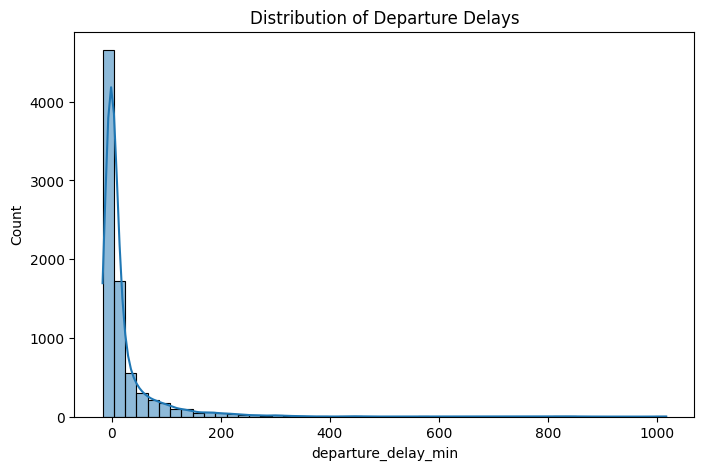

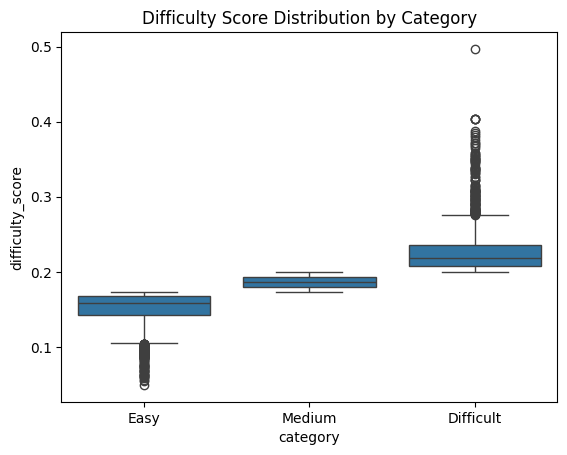

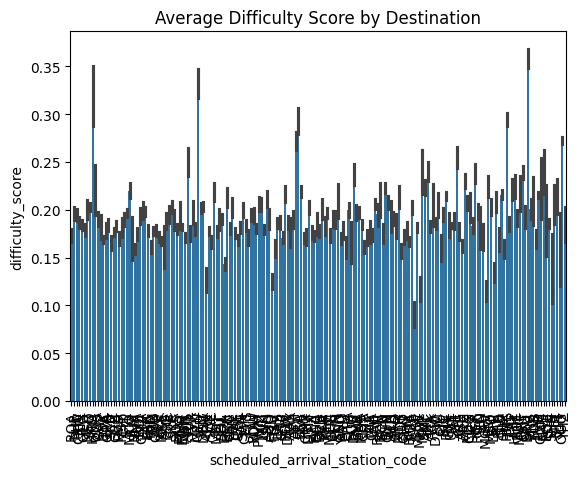

In [29]:
# --- Step 14: Basic Plots for Report ---

plt.figure(figsize=(8,5))
sns.histplot(master["departure_delay_min"], bins=50, kde=True)
plt.title("Distribution of Departure Delays")
plt.show()

sns.boxplot(x="category", y="difficulty_score", data=master)
plt.title("Difficulty Score Distribution by Category")
plt.show()

sns.barplot(x="scheduled_arrival_station_code", y="difficulty_score", data=master, estimator=np.mean)
plt.xticks(rotation=90)
plt.title("Average Difficulty Score by Destination")
plt.show()

In [30]:
from google.colab import files

# Path to the file you saved in Colab
file_path = "/content/sample_data/MySolution/Answer.csv"

# Trigger download to your local machine
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>